In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
plt.rc("axes.spines", top=False, right=False)

from glam.plots import plot_correlation, add_regression_line
from analysis_functions import compute_gaze_influence_score, compute_mean_rt, compute_p_choose_best, add_best_chosen, std, se, q1, q3, iqr

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
np.random.seed(76) # from random.org

# 2.2 Relative model fit (individual level model comparison)

## Load WAICs

In [3]:
waic_summaries = [file for file in os.listdir(os.path.join('results', 'model_comparison', 'additive_vs_multiplicative'))
                  if file.endswith('waic.csv')]

n_krajbich2010 = 39
n_krajbich2011 = 30
n_folke2016 = 24
n_tavares2017 = 25
n = n_krajbich2010 + n_krajbich2011 + n_folke2016 + n_tavares2017

waic = pd.DataFrame(dict(subject=np.arange(n)))
waic['dWAIC'] = np.nan
waic['dSE'] = np.nan
waic['dataset'] = np.nan
waic['warning'] = np.nan

for file in waic_summaries:
    _, _, _, subject, _ = file.split('_')
    subject = int(subject)

    waic_summary = pd.read_csv(os.path.join('results', 'model_comparison',
                                            'additive_vs_multiplicative', file), index_col='Unnamed: 0')
    waic.loc[waic['subject'] == subject, 'dWAIC'] = waic_summary.loc['multiplicative', 'WAIC'] - waic_summary.loc['additive', 'WAIC']
    waic.loc[waic['subject'] == subject, 'dSE'] = waic_summary['dSE'].values[1]
    waic.loc[waic['subject'] == subject, 'warning'] = waic_summary['var_warn'].sum()

waic.sort_values('subject', inplace=True)
waic['dataset'] = np.array(n_krajbich2010 * ['krajbich2010'] + n_krajbich2011 * ['krajbich2011'] + n_folke2016 * ['folke2016'] + n_tavares2017 * ['tavares2017'])

waic.head()

,subject,dWAIC,dSE,dataset,warning
0,0,-0.85,1.00,krajbich2010,0.0
1,1,-0.43,3.19,krajbich2010,0.0
2,2,1.36,1.53,krajbich2010,0.0
3,3,-1.19,1.64,krajbich2010,0.0
4,4,-3.03,1.78,krajbich2010,0.0


# Plot WAIC differences between multiplicative and additive GLAM variants

### Panel a

In [4]:
def figure_si_2a(waic, colors=None, fontsize=8, figsize=(7.5, 2.5), plot_type='bar', log_scale=False, ylim=(-50, 100), plot_legend=True, ax=None):

    # Log transform: add minimum dWAIC + 1, then log-transform, new indifference then at log(minimum dWAIC + 1)
    waic = waic.copy()
    if log_scale:
        min_dWAIC = np.min(waic['dWAIC'])
        indifference_level = np.log(np.abs(min_dWAIC) + 1)
        waic['plotted_dWAIC'] = np.log(waic['dWAIC'] + np.abs(min_dWAIC) + 1)
    else:
        indifference_level = 0
        waic['plotted_dWAIC'] = waic['dWAIC']
    
    if colors is None:
        colors = np.array(['C{}'.format(i) for i in range(10)])

    datasets = ['krajbich2010', 'krajbich2011', 'folke2016', 'tavares2017']
    dataset_labels = ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017']
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    sorting_idx = np.argsort(waic['plotted_dWAIC'])
    color_idx = pd.Categorical(waic['dataset'], categories=datasets).codes
    patches = []
    
    patches = [mpatches.Rectangle((0, 0), 0.5, 1, fc="C{}".format(i))
               for i in range(len(datasets))]

    for i, dataset in enumerate(datasets):

        if plot_type == 'bar':
            ax.bar(np.arange(len(waic))[waic['dataset'][sorting_idx] == dataset],
                   waic['plotted_dWAIC'][sorting_idx][waic['dataset'][sorting_idx] == dataset],
                   color=colors[i])

        else:
            ax.scatter(np.arange(len(waic))[waic['dataset'][sorting_idx] == dataset],
                       waic['plotted_dWAIC'][sorting_idx][waic['dataset'][sorting_idx] == dataset],
                       color=colors[i], marker='+')

    
    # Legend
    if plot_legend:
        ax.legend(patches,
                  ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'],
                  ncol=2,
                  loc='lower right',
                  handlelength=1, handleheight=1,
                  fontsize=6, columnspacing=1,
                  frameon=False)
    
    
    ax.set_xlabel('Participant', fontsize=fontsize)
    if log_scale:
        ax.set_ylabel('Log(dWAIC))', fontsize=fontsize)
    else:
        ax.set_ylabel('WAIC(multiplicative)-\nWAIC(additive)', fontsize=fontsize)
    ax.set_xticks([])
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    
    ax.axhline(indifference_level, color='black', lw=1, zorder=9)
    
    ax.set_ylim(ylim)
    
    
    ax.text(-0.06, 1.1, 'a', transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
    # Font sizes
    ax.tick_params(axis='both', labelsize=8)
    
    return ax

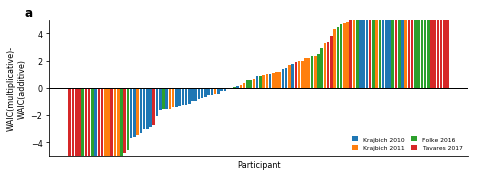

In [5]:
figure_si_2a(waic, ylim=(-5, 5));

In [6]:
waic['dWAIC'].describe()

count    118.000000
mean       1.877966
std       11.749150
min      -36.250000
25%       -1.560000
50%        0.870000
75%        5.167500
max       56.510000
Name: dWAIC, dtype: float64

In [7]:
(waic['dWAIC'] > 0).sum()

67

In [8]:
(waic['dWAIC'] > 0).sum() / len(waic)

0.5677966101694916

### Paneld bcd

In [9]:
# read data
odd = pd.read_csv(os.path.join('data', 'data_odd_aggregate.csv'))
odd.head()

,Unnamed: 0,subject,trial,rt,choice,item_value_0,item_value_1,item_value_2,gaze_0,gaze_1,gaze_2,n_items,dataset
0,1,0,1,1913.0,0.0,3.0,2.0,NaN,0.466578,0.533422,NaN,2,krajbich2010
1,3,0,3,2051.0,1.0,6.0,6.0,NaN,0.464375,0.535625,NaN,2,krajbich2010
2,5,0,5,2504.0,0.0,6.0,2.0,NaN,0.524205,0.475795,NaN,2,krajbich2010
3,7,0,7,1426.0,0.0,6.0,5.0,NaN,1.000000,0.000000,NaN,2,krajbich2010
4,9,0,9,1209.0,0.0,6.0,8.0,NaN,0.429714,0.570286,NaN,2,krajbich2010


In [10]:
# read model predictions for multiplicative and additive variants and concatenate
prediction_additive_list = []
prediction_multiplicative_list = []

# join prediction dataframes
for subject in odd['subject'].unique():
    subject_pred_additive = pd.read_csv(os.path.join('results', 'predictions', 'out_of_sample', 'additive', 'prediction_{}_additive_oos.csv'.format(subject)), index_col=0)
    subject_pred_additive['subject'] = subject    
    prediction_additive_list.append(subject_pred_additive)

    subject_pred_multiplicative = pd.read_csv(os.path.join('results', 'predictions', 'out_of_sample', 'multiplicative', 'prediction_{}_multiplicative_oos.csv'.format(subject)), index_col=0)
    subject_pred_multiplicative['subject'] = subject
    prediction_multiplicative_list.append(subject_pred_multiplicative)

prediction_additive = pd.concat(prediction_additive_list)
prediction_multiplicative = pd.concat(prediction_multiplicative_list)

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  from ipykernel import kernelapp as app
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  app.launch_new_instance()


In [11]:
# discard trials with negative predicted RT
prediction_additive = prediction_additive[prediction_additive['rt'] > 0].copy()
prediction_multiplicative = prediction_multiplicative[prediction_multiplicative['rt'] > 0].copy()

In [12]:
def aggregate_subject_level(data, n_items):
    """
    Aggregates a single dataset to subject level
    """
    data = data.copy()
    
    # add best chosen variable
    data = add_best_chosen(data)
    
    # Summarize variables
    subject_summary = data.groupby('subject').agg({'rt': ['mean', std, 'min', 'max', se, q1, q3, iqr],
                                                   'best_chosen': 'mean'})
    # Influence of gaze on P(choice | value)
    subject_summary['gaze_influence'] = compute_gaze_influence_score(data, n_items=n_items)
    
    subject_summary['dataset'] = data.groupby('subject')['dataset'].head(1).values
    
    return subject_summary

In [13]:
# compute / load individual behavioural measures for odd data and model predictions
odd_summary = pd.DataFrame()
data_summary = pd.DataFrame()
pred_additive_summary = pd.DataFrame()

for di, dataset in enumerate(odd['dataset'].unique()):
    odd_di = odd[odd['dataset'] == dataset].copy()
    n_items = odd_di['n_items'].unique()[0]
    
    odd_summary_di = aggregate_subject_level(odd_di, n_items=n_items)
    
    prediction_additive_di = prediction_additive[prediction_additive['dataset'] == dataset].copy()
    
    pred_additive_summary_di = aggregate_subject_level(prediction_additive_di, n_items=n_items)
    
    
    odd_summary = pd.concat([odd_summary, odd_summary_di])
    pred_additive_summary = pd.concat([pred_additive_summary, pred_additive_summary_di])

pred_additive_summary.to_csv(os.path.join('results', 'predictions', 'out_of_sample', 'descriptives',
                                          'subject_summary_additive_oos.csv'))

pred_multiplicative_summary = pd.read_csv(os.path.join('results',
                                                       'predictions',
                                                       'out_of_sample',
                                                       'descriptives',
                                                       'subject_summary_multiplicative_oos.csv'),
                                         header=[0, 1])

pred_additive_summary = pd.read_csv(os.path.join('results',
                                                 'predictions',
                                                 'out_of_sample',
                                                 'descriptives',
                                                 'subject_summary_additive_oos.csv'),
                                    header=[0, 1])

In [31]:
def figure_si_2bcd(multiplicative, additive,
                 figsize=(7.5, 2.5), colors=None, fontsize=8, alpha=1.0, axs=None, plot_legend=False):

    datasets = ['krajbich2010', 'krajbich2011', 'folke2016', 'tavares2017']

    if colors is None:
        colors = np.array(['C{}'.format(i)
                           for i in range(multiplicative['dataset']['Unnamed: 11_level_1'].unique().size)])
    color_idx = pd.Categorical(multiplicative['dataset']['Unnamed: 11_level_1'], categories=datasets, ordered=True).codes.astype(int)
    
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=figsize, sharex='col', sharey='col')

    # a) Mean RT
    axs[0].scatter(multiplicative['rt']['mean'],
                   additive['rt']['mean'],
                      color=colors[color_idx],
                      marker='+',
                      alpha=alpha)
    axs[0].set_xticks(np.arange(0, 10000, 2000))
    axs[0].set_yticks(np.arange(0, 10000, 2000))
    axs[0].set_xlim(0, 9000)
    axs[0].set_ylim(0, 9000)


    # b) P(choose best)
    axs[1].scatter(multiplicative['best_chosen']['mean'],
                   additive['best_chosen']['mean'],
                      color=colors[color_idx],
                      marker='+',
                      alpha=alpha)
    axs[1].set_xticks(np.arange(0.4, 1.1, 0.2))
    axs[1].set_yticks(np.arange(0.4, 1.1, 0.2))
    axs[1].set_xlim(0.3, 1.0)
    axs[1].set_ylim(0.3, 1.0)



    # c) Gaze Influence
    axs[2].scatter(multiplicative['gaze_influence']['Unnamed: 10_level_1'],
                   additive['gaze_influence']['Unnamed: 10_level_1'],
                      color=colors[color_idx],
                      marker='+',
                      alpha=alpha)
    axs[2].set_xticks(np.arange(-0.2, 1.1, 0.2))
    axs[2].set_yticks(np.arange(-0.2, 1.1, 0.2))
    axs[2].set_xlim(-0.25, 0.85)
    axs[2].set_ylim(-0.25, 0.85)



    axs[0].set_ylabel('Additive', fontsize=fontsize)

    axs[0].set_title('Mean RT (ms)', fontsize=fontsize)
    axs[1].set_title('P(choose best)', fontsize=fontsize)
    axs[2].set_title('Gaze influence\non P(choice | value)', fontsize=fontsize)
     
    axs[0].set_xlabel('Multiplicative', fontsize=fontsize)
    axs[1].set_xlabel('Multiplicative', fontsize=fontsize)
    axs[2].set_xlabel('Multiplicative', fontsize=fontsize)
    
    patches = [mpatches.Rectangle((0, 0), 0.5, 1, fc="C{}".format(i))
               for i in range(len(datasets))]
    if plot_legend:
        axs[0].legend(patches,
                         ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'],
                         loc='upper left',
                         handlelength=1, handleheight=1,
                         fontsize=6,
                         frameon=False)

    # Labels
    for label, ax in zip(list('bcd'), axs.ravel()):
        ax.text(-0.2, 1.15, label, transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Font sizes
        ax.tick_params(axis='both', labelsize=8)

        # Plot diagonal
        ax.plot(ax.get_xlim(), ax.get_xlim(), color='black', linewidth=1, alpha=1.0, zorder=-1)
            
    return axs

## Panels efg (additive model parameters vs. behavioural measures) – in sample

In [15]:
odd_summary.head()

rt                                                     \
                mean          std     min      max          se       q1   
subject                                                                   
0        1704.177778   881.852300   682.0   4142.0  132.944236  1125.00   
1        1728.489796   857.141479   743.0   4602.0  123.717716  1166.00   
2        4078.660000  2623.044800   943.0  12079.0  374.720686  2104.25   
3        1893.545455   633.499496  1045.0   4742.0   96.607767  1436.50   
4        1846.640000  1093.485579   692.0   5891.0  156.212226  1221.50   

                         best_chosen gaze_influence       dataset  
             q3      iqr        mean                               
subject                                                            
0        1970.0   845.00    0.822222      -0.020529  krajbich2010  
1        1937.0   771.00    0.673469       0.247233  krajbich2010  
2        5329.0  3224.75    0.840000       0.028877  krajbich2010  
3        2175.5   739.00    0.704545      -0.022031  krajbich2010  
4        2132.5   911.00    0.840000       0.103622  krajbich2010

In [16]:
estimates = pd.DataFrame()
parameter_names = ['v', 'gamma', 's', 'tau']
for subject in odd_summary.index:
    subject_estimates_df = pd.read_csv(os.path.join('results', 'estimates', 'out_of_sample', 'additive',
                                                    'estimates_{}_additive_oos.csv'.format(subject)),
                                       index_col=0)
    subject_estimates_dict = {parameter: subject_estimates_df.loc[parameter + '__0_0', 'MAP']
                              for parameter in parameter_names}
    subject_estimates_dict['subject'] = subject
    estimates = pd.concat([estimates,
                           pd.DataFrame(subject_estimates_dict,
                                        index=np.ones(1)*subject)])

estimates.head()

,v,gamma,s,tau,subject
0.0,0.000096,1.78,0.008020,0.36,0
1.0,0.000100,7.87,0.010117,0.10,1
2.0,0.000023,0.49,0.008944,1.00,2
3.0,0.000089,1.11,0.004812,0.01,3
4.0,0.000092,6.00,0.009909,0.20,4


In [32]:
def figure_si_2efg(estimates, summary,
                   figsize=(7.5, 2.5), colors=None, fontsize=8, alpha=1.0, axs=None, plot_legend=False):

    datasets = ['krajbich2010', 'krajbich2011', 'folke2016', 'tavares2017']

    if colors is None:
        colors = np.array(['C{}'.format(i)
                           for i in range(summary['dataset'].unique().size)])
    color_idx = pd.Categorical(summary['dataset'], categories=datasets, ordered=True).codes.astype(int)
    
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=figsize, sharex='col', sharey='col')

    # e) log Mean RT ~ log v
    axs[0].scatter(np.log(estimates['v']),
                   np.log(summary['rt']['mean']),
                      color=colors[color_idx],
                      marker='+',
                      alpha=alpha)


    # b) P(choose best) ~ gamma
    axs[1].scatter(estimates['gamma'],
                   summary['best_chosen']['mean'],
                   color=colors[color_idx],
                   marker='+',
                   alpha=alpha)

    # c) Gaze Influence ~ gamma
    axs[2].scatter(estimates['gamma'],
                   summary['gaze_influence'],
                   color=colors[color_idx],
                   marker='+',
                   alpha=alpha)

    axs[0].set_ylabel('Log mean RT (ms)', fontsize=fontsize)
    axs[1].set_ylabel('P(choose best)', fontsize=fontsize)
    axs[2].set_ylabel('Gaze influence\non P(choice | value)', fontsize=fontsize)
     
    axs[0].set_xlabel(r'Log $\hat{v}$', fontsize=fontsize)
    axs[1].set_xlabel(r'$\hat{\gamma}_{additive}$', fontsize=fontsize)
    axs[2].set_xlabel(r'$\hat{\gamma}_{additive}$', fontsize=fontsize)
    
    patches = [mpatches.Rectangle((0, 0), 0.5, 1, fc="C{}".format(i))
               for i in range(len(datasets))]
    if plot_legend:
        axs[0].legend(patches,
                         ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'],
                         loc='upper left',
                         handlelength=1, handleheight=1,
                         fontsize=6,
                         frameon=False)

    # Labels
    for label, ax in zip(list('efg'), axs.ravel()):
        ax.text(-0.2, 1.15, label, transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Font sizes
        ax.tick_params(axis='both', labelsize=8)
            
    return axs

# Mixed effects regressions with random slope and intercept for data sets

In [18]:
from bambi import Model
from pymc3 import plot_posterior

In [19]:
# Format data for mixed model
df = pd.concat([estimates, odd_summary], axis=1)
df['log_rt'] = np.log(df[('rt', 'mean')])
df['log_v'] = np.log(df['v'])
df['best_chosen'] = 100 * df[('best_chosen', 'mean')]
df['gaze_influence'] = 100 * df[('gaze_influence', '')]
df['dataset'] = df[('dataset', '')]

df = df[['subject', 'dataset', 'log_rt', 'best_chosen', 'gaze_influence', 'log_v', 'gamma', 's', 'tau']].copy().reset_index(drop=True)

In [20]:
df.head()

,subject,dataset,log_rt,best_chosen,gaze_influence,log_v,gamma,s,tau
0,0,krajbich2010,7.440838,82.222222,-2.052946,-9.251162,1.78,0.008020,0.36
1,1,krajbich2010,7.455003,67.346939,24.723267,-9.210340,7.87,0.010117,0.10
2,2,krajbich2010,8.313524,84.000000,2.887728,-10.680016,0.49,0.008944,1.00
3,3,krajbich2010,7.546206,70.454545,-2.203105,-9.326874,1.11,0.004812,0.01
4,4,krajbich2010,7.521123,84.000000,10.362165,-9.293722,6.00,0.009909,0.20


In [21]:
n_samples = 20000

In [22]:
result_file = os.path.join('results', 'mixed_effects_models', 'si2_parameter_behavior_e_v_rt.csv')

if not os.path.isfile(result_file):

    model_e = Model(df)
    result_e = model_e.fit('log_rt ~ log_v',
                           random=['log_v|dataset'],
                           categorical=['dataset'],
                           samples=n_samples,
                           chains=2)

    summary_e = result_e.summary(ranefs=True)
    summary_e.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary_e = pd.read_csv(result_file, index_col=0)
summary_e

Loading previous results from "results/mixed_effects_models/si2_parameter_behavior_e_v_rt.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
log_v|dataset[folke2016],-0.007553,0.018307,-4.943845e-02,0.025038,82,1.000463
log_v|dataset[krajbich2010],0.003446,0.017846,-3.141836e-02,0.047721,113,0.999984
log_v|dataset[krajbich2011],-0.000548,0.017943,-4.390548e-02,0.031085,207,1.001289
log_v|dataset[tavares2017],-0.002809,0.016873,-4.140546e-02,0.032624,496,1.000451
Intercept,-0.059328,0.293894,-5.833678e-01,0.587180,2787,1.000275
log_v,-0.801583,0.030995,-8.674843e-01,-0.740502,1100,1.000476
1|dataset_sd,0.170266,0.173434,1.382837e-05,0.571532,881,1.002196
log_rt_sd,0.124116,0.008479,1.084129e-01,0.141256,27974,0.999998
1|dataset[folke2016],0.019922,0.158392,-3.247523e-01,0.356609,981,1.000099
1|dataset[krajbich2010],0.027223,0.154322,-2.577884e-01,0.414204,783,1.000025


In [23]:
result_file = os.path.join('results', 'mixed_effects_models', 'si2_parameter_behavior_f_gamma_best_chosen.csv')

if not os.path.isfile(result_file):
    model_f = Model(df)
    result_f = model_f.fit('best_chosen ~ gamma',
                           random=['gamma|dataset'],
                           categorical=['dataset'],
                           samples=n_samples,
                           chains=2)
    plot_posterior(model_f.backend.trace, varnames=['gamma'], ref_val=0, color='lightblue', point_estimate='mode');
    plt.savefig(os.path.join('results', 'mixed_effects_models', 'si2_parameter_behavior_f_gamma_best_chosen_posteriorplot.png'))
    summary_f = result_f.summary(ranefs=True)
    summary_f.loc['gamma', 'P(>0)'] = np.mean(model_f.backend.trace.get_values('gamma') > 0)
    summary_f.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary_f = pd.read_csv(result_file, index_col=0)
summary_f

Loading previous results from "results/mixed_effects_models/si2_parameter_behavior_f_gamma_best_chosen.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin,P(>0)
gamma,-0.537565,0.223608,-0.965524,-0.045008,5693,1.000151,0.020975
gamma|dataset[folke2016],-0.141117,0.244266,-0.704087,0.283727,5531,1.000206,NaN
gamma|dataset[krajbich2010],0.091930,0.237398,-0.394369,0.602955,6725,1.000010,NaN
gamma|dataset[krajbich2011],-0.145570,0.262335,-0.727224,0.315662,7140,1.000312,NaN
gamma|dataset[tavares2017],0.129105,0.274636,-0.355712,0.792443,10853,1.000144,NaN
Intercept,81.822196,3.905273,73.836664,90.126193,4955,1.000153,NaN
best_chosen_sd,8.062068,0.543640,7.007182,9.120379,31393,1.000016,NaN
1|dataset_sd,7.280638,3.274886,1.766365,14.133969,7216,1.000198,NaN
1|dataset[folke2016],-6.010431,4.270641,-14.746953,2.422320,6318,1.000047,NaN
1|dataset[krajbich2010],1.324486,4.003605,-7.001742,9.574366,5815,1.000214,NaN


In [24]:
result_file = os.path.join('results', 'mixed_effects_models', 'si2_parameter_behavior_g_gamma_gaze_influence.csv')

if not os.path.isfile(result_file):
    model_g = Model(df)
    result_g = model_g.fit('gaze_influence ~ gamma',
                           random=['gamma|dataset'],
                           categorical=['dataset'],
                           samples=n_samples,
                           chains=2)
    summary_g = result_g.summary(ranefs=True)
    summary_g.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary_g = pd.read_csv(result_file, index_col=0)
summary_g

Loading previous results from "results/mixed_effects_models/si2_parameter_behavior_g_gamma_gaze_influence.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
gamma,1.303419,0.471874,0.344002,2.225488,906,1.001520
gamma|dataset[folke2016],-0.474046,0.484567,-1.434355,0.534125,1130,1.001360
gamma|dataset[krajbich2010],0.706553,0.530309,-0.247776,1.788569,980,1.000965
gamma|dataset[krajbich2011],0.351697,0.525414,-0.618584,1.453836,1114,1.001368
gamma|dataset[tavares2017],0.106707,0.536483,-0.900275,1.275864,1561,1.000761
Intercept,12.823820,4.680674,2.973146,21.899099,3339,1.001046
gaze_influence_sd,11.012883,0.762348,9.548602,12.526434,24978,0.999982
1|dataset_sd,7.931714,4.194953,0.527004,16.198523,5412,1.000103
1|dataset[folke2016],7.563435,5.485727,-2.367936,18.789816,4509,1.000770
1|dataset[krajbich2010],-1.203179,4.854251,-11.537931,7.994242,3757,1.000844


# Figure SI 2

In [33]:
def figure_si_2(waic, 
                pred_multiplicative_summary, pred_additive_summary, 
                estimates, odd_summary, summary_e, summary_f, summary_g, 
                figsize=(7.5, 7.5)):
    
    fig = plt.figure(figsize=figsize)
    
    ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
    ax1 = plt.subplot2grid((3, 3), (1, 0))
    ax2 = plt.subplot2grid((3, 3), (1, 1))
    ax3 = plt.subplot2grid((3, 3), (1, 2))
    ax4 = plt.subplot2grid((3, 3), (2, 0))
    ax5 = plt.subplot2grid((3, 3), (2, 1))
    ax6 = plt.subplot2grid((3, 3), (2, 2))
    
    
    figure_si_2a(waic, ylim=(-5, 5), ax=ax0)
    figure_si_2bcd(pred_multiplicative_summary, pred_additive_summary, axs=np.array([ax1, ax2, ax3]), plot_legend=False)
    figure_si_2efg(estimates, odd_summary, axs=np.array([ax4, ax5, ax6]), plot_legend=False)
    
    add_regression_line(ax4, summary_e.loc['Intercept', 'mean'], summary_e.loc['log_v', 'mean'], linewidth=1)
    add_regression_line(ax5, summary_f.loc['Intercept', 'mean'] / 100, summary_f.loc['gamma', 'mean'] / 100, linewidth=1)
    add_regression_line(ax6, summary_g.loc['Intercept', 'mean'] / 100, summary_g.loc['gamma', 'mean'] / 100, linewidth=1)
    
    fig.tight_layout()
    
    return fig, [ax0, ax1, ax2, ax3, ax4, ax5, ax6]

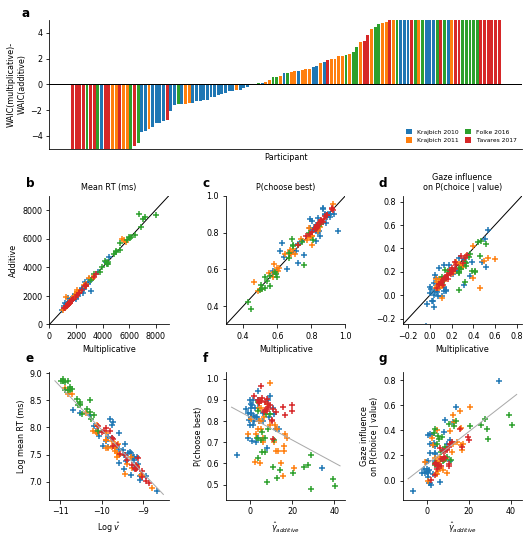

In [34]:
figure_si_2(waic, 
            pred_multiplicative_summary, pred_additive_summary, 
            estimates, odd_summary, summary_e, summary_f, summary_g)
plt.savefig('results/figures/si_figure_2_multiplicative_vs_additive.png', dpi=330, bbox_inches='tight')
plt.show()